# 1D heat conduction example
Jean C. Ragusa

Texas A&M University

jean.ragusa@tamu.edu

# General problem definition
Consider a 1D **nonlinear** heat conduction problem
$$ -\frac{d}{dx} k(x,T)\frac{dT}{dx} = q(x)
$$
where the conductivity $k(x,T)$ is a function of space **and** temperature. 

As an example, we can use
$$k(x,T)=k^0(x) + k^1(x)T$$
Hence, we are solving:
$$ -\frac{d}{dx} (k^0(x) + k^1(x) T)\frac{dT}{dx} = q(x)
$$
**Boundary conditions**:
- reflective at $x=0$: $\quad \left.\tfrac{dT}{dx}\right|_0 = 0$
- imposed temperature (Dirichlet bc) at $x=L$: $\quad T(L)=T_{bc}$

More generally, on the boundary, one may have :
* a natural boundary condition $$ a T + k\partial_n T = c$$
* or a fixed, imposed value $$ T = \text{given}$$

For example, the convective heat transfer boundary value can be written as:

$$
-k\partial_n T  = h(T - T^{\infty})
$$

So $a=h$, the convective heat exchange coefficient, and $c=h T^\infty$, with $T^\infty$ the far-field cooling temperature.

**Linear version** of the problem: set $k^1(x) = 0$

### load python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg
import time

# 1-D slab mesh and material properties
We give material properties "per zone" and then replicate them as many times as needed to assign them to a mesh cell (mesh resolution is a refinement of the material zone layout).

In [2]:
def create_slab_mesh(n_ref,zone_widths):
    # input: 
    #    n_ref: integer (how many times each zone is to be refined)
    #    zone_widths: array of zone widths
    # output:
    #    x: array of cell interface positions
    #    zone_widths: array of cell widths
    #    cell2mat: given a cell index, this returns the material ID in that cell
    
    if len(zone_widths) != len(n_ref):
        raise ValueError("dx and nref should have same length")
    
    # compute cell widths
    dx = np.repeat(zone_widths/n_ref, n_ref)
    
    # cell interfaces
    x = np.zeros(len(dx)+1)
    for i in range(len(dx)):
        x[i+1] = x[i] + dx[i]
        
    # create cell2mat array
    cell2mat = np.repeat( np.arange(len(zone_widths)), n_ref)
    
    # middle point
    xm = 0.5 * (x[1:]+x[:-1])
    
    return x, xm, dx, cell2mat

### small demo: 2-zones, of width 0.4 and 0.1, and a refinement factor of 10 in zone-1 and 4 in zone-2

cell interfaces= [0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4   0.425
 0.45  0.475 0.5  ]

cell middles   = [0.02   0.06   0.1    0.14   0.18   0.22   0.26   0.3    0.34   0.38
 0.4125 0.4375 0.4625 0.4875]

cell widths    = [0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.025 0.025
 0.025 0.025]


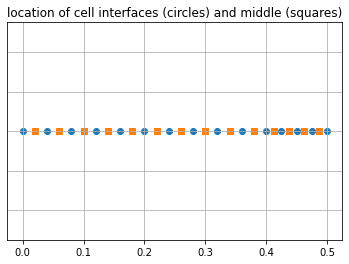

In [3]:
x, xm, dx, cell2mat = create_slab_mesh(n_ref=np.array([10,4],dtype=int),zone_widths=np.array([0.4,0.1]))

print('cell interfaces=',x)
print('\ncell middles   =',xm)
print('\ncell widths    =',dx)
# plot
plt.figure()
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('none') 
plt.scatter(x, np.zeros(len(x)))
plt.scatter(xm, np.zeros(len(xm)),marker='s')
plt.title('location of cell interfaces (circles) and middle (squares)')
plt.grid()
plt.show()

# Linear version of the problem: system matrix

One way the discrete expression can be obtained is by integrating the governing equation for $x \in [x_{i-1/2},x_{i+1/2}]$:

$$
\int_{x_{i-1/2}}^{x_{i+1/2}}dx\, \left( -\frac{d}{dx} k^0(x)\frac{dT}{dx} = q(x) \right)
$$

Thus, we obtain a **vertex-centered** simple finite difference for the **linear** term $-\frac{d}{dx}k^0\frac{dT}{dx} = q$

$$
-k^0_{i+1/2}\frac{T_{i+1}-T_i}{\Delta x_{i+1/2}}
+
k^0_{i-1/2}\frac{T_i-T_{i-1}}{\Delta x_{i-1/2}}
=
\frac{q_{i+1/2}\Delta x_{i+1/2}}{2} + \frac{q_{i-1/2}\Delta x_{i-1/2}}{2}
$$

where the full integer indices denote nodal (vertex) values and the half-integer indices denote cell values. $\Delta x_{i+1/2}=x_{i+1}-x_i$.




The first row encodes the left boundary condition. It is obtained by integrating the governing law for $x \in [0,x_{1/2}]$:

$$
\int_{0}^{x_{1/2}}dx\, \left( -\frac{d}{dx} k^0(x)\frac{dT}{dx} = q(x) \right)
= 
-k^0_{1/2}\frac{T_1-T_0}{\Delta x_{1/2}}
+k^0_{0}\left.\partial_x T \right|_0
=
\frac{q_{1/2}\Delta x_{1/2}}{2} 
$$

For a symmetry boundary condition, $\left.\partial_x T \right|_0 = 0$.

Finally, the last row simply encodes the Dirichlet boundary condition $A_{N,N} T_N=T_{Dirichlet}$ with $A_{N,N}=1$.
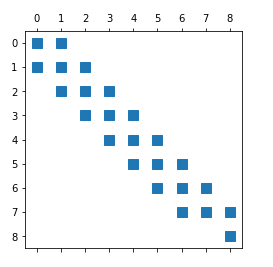

Resulting linear system:
$$ A T = b$$
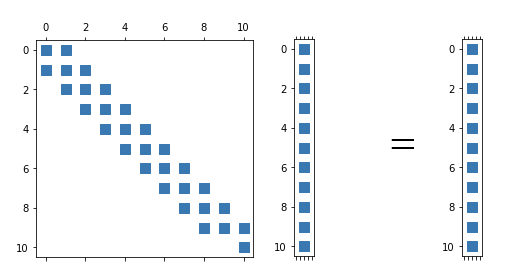

# Sparse storage. We build the  triadiagonal matrix but store it sparsely

# build linear system matrix

In [4]:
def build_matrix_at_once(cond_arr, bc, xm, dx, mat2cell):
    # input: 
    #    cond_arr: conductivity array (length = number of material zones)
    #    xm   : array of cell middle points (length = number of cells)
    #    dx   : array of cell widths (length = number of cells)
    #    cell2mat: given a cell index, this returns the material ID in that cell
    # output:
    #    K: matrix

    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1
    
    # evaluate mat property per cell
    cond_ = cond_arr[mat2cell]
    cond = np.zeros(n_cells)
    for i,(kfunc,xmiddle) in enumerate(zip(cond_,xm)):
        cond[i] = kfunc(xmiddle)

    # matrix
    K = sparse.lil_matrix((n_pts,n_pts))
    for i in range(0,n_pts):
        if i>0:
            K[i,i-1] = -cond[i-1]/dx[i-1]
            K[i,i  ] = cond[i-1]/dx[i-1]
        if i<n_pts-1:
            K[i,i+1] = -cond[i  ]/dx[i  ]
            K[i,i  ]+= cond[i]/dx[i]
    
    # apply left bc
    if bc["left"]["type"] == "natural":
        K[0,0] += bc["left"]["value_a"]
    elif bc["left"]["type"] == "dirichlet":
        K[0,:2] = 0.
        K[0,0]  = 1.
    else:
        raise ValueError("unknown bc type on left")
        
    # apply right bc
    if bc["right"]["type"] == "natural":
        K[-1,-1] += bc["right"]["value_a"]
    elif bc["right"]["type"] == "dirichlet":
        K[-1,-2:] = 0.
        K[-1,-1]  = 1.
    else:
        raise ValueError("unknown bc type on right")

    return K

# build linear system rhs

In [5]:
def build_rhs_at_once(qext_arr, bc, xm, dx, mat2cell):
    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1

    # evaluate src property per cell
    qext_ = qext_arr[mat2cell]
    qext = np.zeros(n_cells)
    for i,(qfunc,xmiddle) in enumerate(zip(qext_,xm)):
        qext[i] = qfunc(xmiddle)    
    #  rhs
    rhs = np.zeros(n_pts)
    rhs[:-1] += qext*dx/2
    rhs[1:]  += qext*dx/2
    
    # apply left bc
    if bc["left"]["type"] == "natural":
        rhs[0] += bc["left"]["value_c"]
    elif bc["left"]["type"] == "dirichlet":
        rhs[0] = bc["left"]["value"]
    else:
        raise ValueError("unknown bc type on left")
        
    # apply right bc
    if bc["right"]["type"] == "natural":
        rhs[-1] += bc["right"]["value_c"]
    elif bc["right"]["type"] == "dirichlet":
        rhs[-1] = bc["right"]["value"]
    else:
        raise ValueError("unknown bc type on right")

    return rhs

# routine that builds the whole linear system and solves for $T$

In [6]:
def solve_linear_at_once(cond_arr, qext_arr, bc, xm, dx, matcell):  
       
    # build linear system
    A = build_matrix_at_once(cond_arr, bc, xm, dx, mat2cell)
    rhs  = build_rhs_at_once(qext_arr, bc, xm, dx, mat2cell)

    # solve linear system
    T  = linalg.spsolve(A.tocsc(), rhs)
    
    return T

# problem definition and linear solve
## 1 material, mat prop are piece-wise constant

Linear heat conduction
$$ -\frac{d}{dx} k^0(x)\frac{dT}{dx} = q(x) $$


| Zone ID | $x$   | $k^0$ | $q$ |
| :---    | :---: | ---   | --- |
| I  | \begin{equation}x \in [0.0, 5.0]\end{equation} | 2.0  | 350. |  

Reflective left, Dirichlet right; exact analytical solution:

$$T(x) = \frac{q}{2k}(L^2-x^2) + T_{\text{dir}}
$$

Dirichlet left, convective right exact analytical solution:

$$T(x) = -\frac{q}{2k}x^2 + bx + T_{\text{dir}}
$$
with 
$$
b = \frac{T_\infty-T_{\text{dir}} -\frac{qL}{k}\left( \frac{k}{h} + L \right)}{L+k/h}
$$

Max T value =  758.2307692307601
Min T value =  114.90384615384497


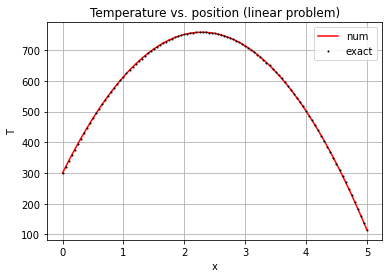

In [7]:
# conductivity functions per zone
cond_arr = []
cond_arr.append( lambda x: 2.0 + 0.*x)
cond_arr = np.asarray(cond_arr)

# external volumetric heat source functions per zone
qext_arr = []
qext_arr.append( lambda x: 350.0 + 0.*x)
qext_arr = np.asarray(qext_arr)

# geometry
width   = np.array([ 5.])
n_ref = np.array([100], dtype=int)

x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

# boundary conditions
bc = {}
h = 10.
T_inf = 20.
bc_hco  = {"type": "natural"  , "value_a": h, "value_c": h*T_inf}
T_dir = 300.
bc_dir = {"type": "dirichlet", "value": T_dir}
bc_sym = {"type": "natural"  , "value_a": 0., "value_c": 0.}

bc["left"]  = bc_sym
bc["right"] = bc_dir

bc["left"]  = bc_dir
bc["right"] = bc_hco

# solve
T_lin = solve_linear_at_once(cond_arr, qext_arr, bc, xm, dx, mat2cell)
print('Max T value = ',np.max(T_lin))
print('Min T value = ',np.min(T_lin))

plt.figure()
plt.plot(x,T_lin,'r', label='num')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position (linear problem)')
plt.grid(True)


# analytical answer, reflective left, Dirichlet right:
L = np.sum(width)
if (bc["left"]["type"]=="natural" and np.abs(bc["left"]["value_a"])<1e-6 \
    and np.abs(bc["left"]["value_c"])<1e-6 and bc["right"]["type"]=="dirichlet"):
    q = qext_arr[0](0.)
    k = cond_arr[0](0.)
    T_exact = lambda x: q/2/k*(L**2 - x**2) + T_dir
# analytical answer, Dirichlet left, heat transfer right:
elif (bc["right"]["type"]=="natural" and np.abs(bc["right"]["value_a"])>1e-6 \
    and np.abs(bc["right"]["value_c"])>1e-6 and bc["left"]["type"]=="dirichlet"):
    q = qext_arr[0](0.)
    k = cond_arr[0](0.)
    b = T_inf-T_dir + q*L/k*(L/2+k/h)
    b/= (L+k/h)
    T_exact = lambda x: -q/2/k*x**2 + b*x + T_dir
    
plt.plot(x,T_exact(x),'k.', ms=2, label='exact')
plt.legend()
plt.show()

## 2 materials, mat prop are piece-wise constant
Linear heat conduction
$$ -\frac{d}{dx} k^0(x)\frac{dT}{dx} = q(x) $$


| Zone ID | $x$   | $k^0$ | $q$ |
| :---    | :---: | ---   | --- |
| I  | \begin{equation}x \in [0.0, 5.0]\end{equation} | 2.0  |  350. |  
| II | \begin{equation}x \in [5.0, 8.0]\end{equation} | 5.0  |   50. | 

Max T value =  1010.9414062499819
Min T value =  110.23437499999824


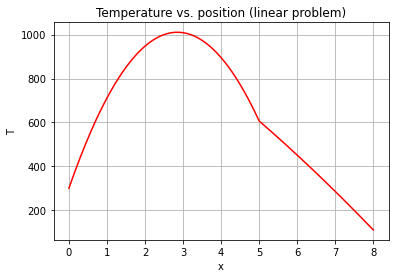

In [8]:
# conductivity functions per zone
cond_arr = []
cond_arr.append( lambda x: 2.0+0.*x)
cond_arr.append( lambda x: 5.0+0.*x)
cond_arr = np.asarray(cond_arr)

# external volumetric heat source functions per zone
qext_arr = []
qext_arr.append( lambda x: 350.+0.*x)
qext_arr.append( lambda x:  50.+0.*x)
qext_arr = np.asarray(qext_arr)

# geometry
width   = np.array([ 5., 3.])
n_ref = np.array([100, 50], dtype=int)

x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

# boundary conditions
bc = {}
h = 10.
T_inf = 20.
bc_hco  = {"type": "natural"  , "value_a": h, "value_c": h*T_inf}
T_dir = 300.
bc_dir = {"type": "dirichlet", "value": T_dir}
bc_sym = {"type": "natural"  , "value_a": 0., "value_c": 0.}

bc["left"]  = bc_dir
bc["right"] = bc_hco

# solve
T_lin = solve_linear_at_once(cond_arr, qext_arr, bc, xm, dx, mat2cell)
print('Max T value = ',np.max(T_lin))
print('Min T value = ',np.min(T_lin))

plt.figure()
plt.plot(x,T_lin,'r', label='num')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position (linear problem)')
plt.grid(True)

## Space-dependent properties
### Manufactured solution
If we select
$$ T(x) = T_2 x^2 + T_0$$
and 
$$ k(x)= k_1 x+k_0,$$
then the volumetric source has to be
$$
-\frac{d}{dx}(k_1x+k_0)\frac{d}{dx}(T_2 x^2 + T_0)
=
-\frac{d}{dx}(k_1x+k_0)(2T_2x)
=
-(2T_2(k_1x+k_0) + k_1 2T_2x)
=-4T_2k_1 x - 2T_2k_0
$$

Therefore, if we encode this conductivity function, this volumetric heat source function, and use the exact temeprature function for the left and right Dirichlet (fixed) boundary conditions, then we can keep verifying our code

Max T value =  1450.0
Min T value =  200.00000000003334


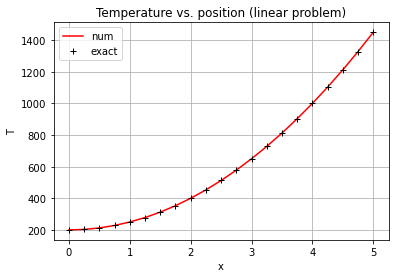

In [9]:
k1, k0 = 2.,3.
T2, T0 = 50., 200.
T_exact = lambda x: T2*x**2 + T0

cond_arr = []
cond_arr.append( lambda x: k1*x + k0)
cond_arr = np.asarray(cond_arr)

qext_arr = []
qext_arr.append( lambda x: -4*T2*k1*x-2*T2*k0)
qext_arr = np.asarray(qext_arr)

width   = np.array([ 5.])
n_ref = np.array([20], dtype=int)

x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

bc = {}
bc_dirL = {"type": "dirichlet", "value": T_exact(0)}
bc_dirR = {"type": "dirichlet", "value": T_exact(width[-1])}
bc["left"]  = bc_dirL
bc["right"] = bc_dirR

T_lin = solve_linear_at_once(cond_arr, qext_arr, bc, xm, dx, mat2cell)
print('Max T value = ',np.max(T_lin))
print('Min T value = ',np.min(T_lin))

plt.figure()
plt.plot(x,T_lin,'r', label='num')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position (linear problem)')
plt.grid(True)

plt.plot(x,T_exact(x),'k+', label='exact')
plt.legend()
plt.show()

# Nonlinear version of the problem
Same as before except:
$$
-k_{i+1/2}\frac{T_{i+1}-T_i}{\Delta x_{i+1/2}}
+
k_{i-1/2}\frac{T_i-T_{i-1}}{\Delta x_{i-1/2}}
=
\frac{q_{i+1/2}\Delta x_{i+1/2}}{2} + \frac{q_{i-1/2}\Delta x_{i-1/2}}{2}
$$

which we can split into a linear and a nonlinear part:
$$
-\left(k^0_{i+1/2}+k^1_{i+1/2}T_{i+1/2}\right)\frac{T_{i+1}-T_i}{\Delta x_{i+1/2}}
+
\left(k^0_{i-1/2}+k^1_{i-1/2}T_{i-1/2}\right)\frac{T_i-T_{i-1}}{\Delta x_{i-1/2}}
=
\frac{q_{i+1/2}\Delta x_{i+1/2}}{2} + \frac{q_{i-1/2}\Delta x_{i-1/2}}{2}
$$

So building the nonlinear term is fairly identical:

In [10]:
def build_nonlinear_term(T, k1_arr, xm, dx, mat2cell):
    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1
    
    # evaluate mat property per cell
    cond_ = k1_arr[mat2cell]
    cond = np.zeros(n_cells)
    for i,(kfunc,xmiddle) in enumerate(zip(cond_,xm)):
        cond[i] = kfunc(xmiddle)
        
    T_ave = (T[:-1] + T[1:])/2
    cond = cond*T_ave

    # matrix
    K = sparse.lil_matrix((n_pts,n_pts))
    for i in range(0,n_pts):
        if i>0:
            K[i,i-1] = -cond[i-1]/dx[i-1]
            K[i,i  ] = cond[i-1]/dx[i-1]
        if i<n_pts-1:
            K[i,i+1] = -cond[i  ]/dx[i  ]
            K[i,i  ]+= cond[i]/dx[i]

    # zero-out bc if Dirichlet (they were already applied in the linear part)
    if bc["left"]["type"] == "dirichlet":
        K[0,:2] = 0.
    if bc["right"]["type"] == "dirichlet":
        K[-1,-2:] = 0.
    
    return K@T

### nonlinear solution technique

The nonlinear problem looks like:

$$
Ax + f(x) = b
$$

We can proceed iteratively (fixed-point), with a succession of linear solves:

$$
Ax^{\ell+1} = b - f(x^{\ell})
$$

or we can just re-cast everything into a large nonlinear system:

$$
F(x) = Ax + f(x) - b = 0
$$
and solve for the root of $F$.

In [11]:
from scipy.optimize import fsolve

def solve_nonlinear(cond0_arr, cond1_arr, qext_arr, bc, xm, dx, matcell, T_init):  

    # build linear system
    A = build_matrix_at_once(cond0_arr, bc, xm, dx, mat2cell)
    rhs  = build_rhs_at_once(qext_arr, bc, xm, dx, mat2cell)

    F = lambda Temp: build_nonlinear_term(Temp, cond1_arr, xm, dx, mat2cell)

    f = lambda Temp: A@Temp + F(Temp) - rhs

    # make sure the initial guess satisfies the Dirichlet BC
    if bc["left"]["type"] == "dirichlet":
        T_init[0] = bc["left"]["value"]
    if bc["right"]["type"] == "dirichlet":
        T_init[-1] = bc["right"]["value"]

    # solve
    T  = fsolve(f, T_init)
    
    return T

## 2-material example

Max T value =  359.3081687310883
Min T value =  300.0


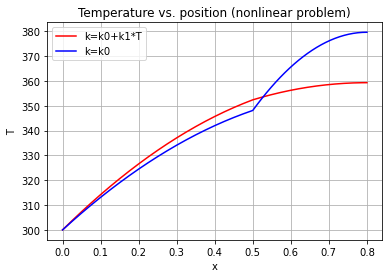

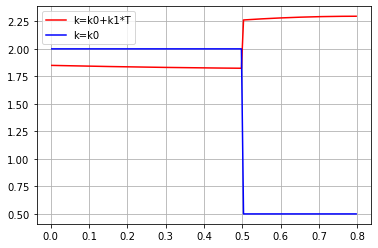

In [12]:
# conductivity functions per zone
cond0_arr = []
cond0_arr.append( lambda x: 2.0+0.*x)
cond0_arr.append( lambda x: 0.5+0.*x)
cond0_arr = np.asarray(cond0_arr)

cond1_arr = []
cond1_arr.append( lambda x: -0.0005+0.*x)
cond1_arr.append( lambda x: +0.005+0.*x)
cond1_arr = np.asarray(cond1_arr)

# external volumetric heat source functions per zone
qext_arr = []
qext_arr.append( lambda x: 350.+0.*x)
qext_arr.append( lambda x: 350.+0.*x)
qext_arr = np.asarray(qext_arr)

# geometry
width   = np.array([ 0.5, 0.3])
n_ref = np.array([100, 50], dtype=int)

x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

# boundary conditions
bc = {}
h = 10.
T_inf = 20.
bc_hco  = {"type": "natural"  , "value_a": h, "value_c": h*T_inf}
T_dir = 300.
bc_dir = {"type": "dirichlet", "value": T_dir}
bc_sym = {"type": "natural"  , "value_a": 0., "value_c": 0.}

bc["left"]  = bc_dir
bc["right"] = bc_sym

# solve
T_lin = solve_linear_at_once(cond0_arr, qext_arr, bc, xm, dx, mat2cell)
T_init = np.zeros(len(x))
T_nonlin = solve_nonlinear(cond0_arr, cond1_arr, qext_arr, bc, xm, dx, mat2cell, T_init)
print('Max T value = ',np.max(T_nonlin))
print('Min T value = ',np.min(T_nonlin))

plt.figure()
plt.plot(x,T_nonlin,'r', label='k=k0+k1*T')
plt.plot(x,T_lin   ,'b', label='k=k0')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position (nonlinear problem)')
plt.grid(True)
plt.legend()

# evaluate mat property per cell
cond0_ = cond0_arr[mat2cell]
cond1_ = cond1_arr[mat2cell]
T_ave = (T_nonlin[:-1] + T_nonlin[1:])/2
cond_lin = np.zeros(len(xm))
cond = np.zeros(len(xm))
for i,(k0,k1,xx) in enumerate(zip(cond0_,cond1_,xm)):
    cond_lin[i] = k0(xx)
    cond[i] = k0(xx) + k1(xx)*T_ave[i]

plt.figure()
plt.plot(xm,cond,'r', label='k=k0+k1*T')
plt.plot(xm,cond_lin,'b',label='k=k0')
plt.legend()
plt.grid(True)

# Back to the linear problem. Let's generate some snapshots
## 2 materials, mat prop are piece-wise constant
Linear heat conduction
$$ -\frac{d}{dx} k^0(x)\frac{dT}{dx} = q(x) $$


| Zone ID | $x$   | $k^0$ | $q$ |
| :---    | :---: | ---   | --- |
| I  | \begin{equation}x \in [0.0, 5.0]\end{equation} | 2.0  |  350. |  
| II | \begin{equation}x \in [5.0, 8.0]\end{equation} | 5.0  |   50. | 

In [13]:
N_snapshots = 50
import random as random

a = 0.2
k_zone1 = np.random.uniform(  2*(1-a),  2*(1+a),N_snapshots)
k_zone2 = np.random.uniform(  5*(1-a),  5*(1+a),N_snapshots)
q_zone1 = np.random.uniform(350*(1-a),350*(1+a),N_snapshots)
q_zone2 = np.random.uniform( 50*(1-a), 50*(1+a),N_snapshots)

print(k_zone1)

[2.12591119 1.92396841 1.80737875 1.91881605 2.04859135 1.82926517
 2.15169785 1.99939864 1.88685353 2.0461455  1.79116269 1.90517318
 1.86152145 2.3687717  2.18197196 2.0410052  2.06540487 2.01976651
 1.93446524 1.87434232 2.10823523 2.02807581 2.17093167 1.78942155
 1.93438556 1.67575946 1.66950858 2.0497545  2.15358984 1.81232983
 2.35114577 2.05053134 2.16054071 1.91839392 1.78256549 1.67365185
 1.73848981 1.64494697 2.28983002 2.34615901 2.00629049 2.28174633
 1.99443791 2.39161984 1.97492721 2.39089498 2.16288168 2.00091927
 2.23959623 1.94173743]


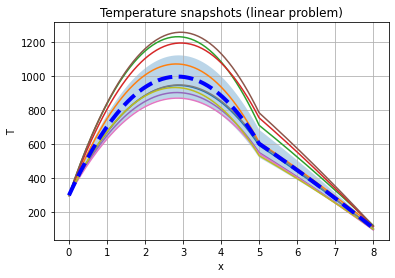

In [14]:
# geometry
width   = np.array([ 5., 3.])
n_ref = np.array([100, 50], dtype=int)

x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

T_snapshots = np.zeros((len(x),N_snapshots))

# boundary conditions
bc = {}
h = 10.
T_inf = 20.
bc_hco  = {"type": "natural"  , "value_a": h, "value_c": h*T_inf}
T_dir = 300.
bc_dir = {"type": "dirichlet", "value": T_dir}
bc_sym = {"type": "natural"  , "value_a": 0., "value_c": 0.}

bc["left"]  = bc_dir
bc["right"] = bc_hco


# loop to generate snapshots
for i,(k1,k2,q1,q2) in enumerate(zip(k_zone1,k_zone2,q_zone1,q_zone2)):
    # conductivity functions per zone
    cond_arr = []
    cond_arr.append( lambda x_: k1+0.*x_)
    cond_arr.append( lambda x_: k2+0.*x_)
    cond_arr = np.asarray(cond_arr)

    # external volumetric heat source functions per zone
    qext_arr = []
    qext_arr.append( lambda x_: q1+0.*x_)
    qext_arr.append( lambda x_: q2+0.*x_)
    qext_arr = np.asarray(qext_arr)

    # solve
    T_snapshots[:,i] = solve_linear_at_once(cond_arr, qext_arr, bc, xm, dx, mat2cell)

    
mean_temp = np.mean(T_snapshots,axis=1)
std_temp  = np.std(T_snapshots,axis=1)

plt.figure()
for i in range(9):
    plt.plot(x,T_snapshots[:,i])
plt.xlabel('x')
plt.ylabel('T')
plt.plot(x,mean_temp,'b--', linewidth=4, label='mean')
plt.fill_between(x,mean_temp-std_temp,mean_temp+std_temp,alpha=.3)
plt.title('Temperature snapshots (linear problem)')
plt.grid(True)

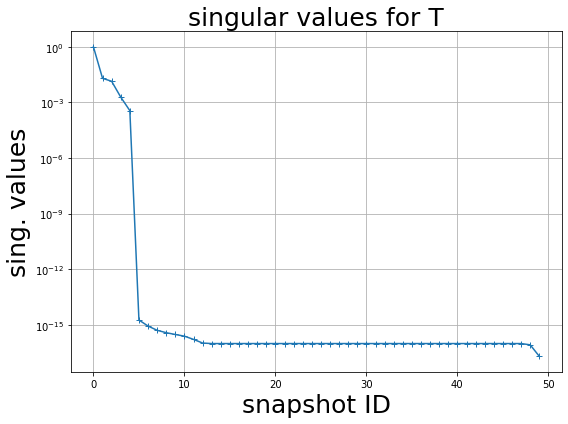

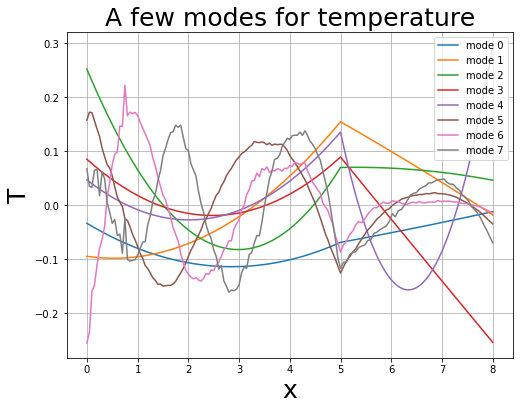

In [15]:
U_all, S, _ = np.linalg.svd(T_snapshots[:,:],full_matrices=False,compute_uv=True)

plt.figure(figsize=(8,6))
plt.semilogy(S/np.max(S),'-+')
plt.xlabel('snapshot ID',fontsize=25)
plt.ylabel('sing. values',fontsize=25)
plt.title('singular values for T',fontsize=25)
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for i in range(8):
    plt.plot(x,U_all[:,i],label='mode '+str(i))
    plt.grid(True)
    plt.legend()
    plt.title('A few modes for temperature',fontsize=25)
plt.xlabel('x',fontsize=25)
plt.ylabel('T',fontsize=25)
plt.show()

# 3-material zones

In [16]:
np.random.seed(123456789)

N_snapshots = 50
import random as random

width   = np.array([ 5., 8., 5.])
n_ref = np.array([100, 100, 100], dtype=int)

min_vals = np.array([2.,5., 3.,300, 500, 450])
max_vals = np.array([4.,15.,6.,600,1500,1450])
dif_vals = max_vals - min_vals
randnumber = np.random.uniform(low=np.zeros((6,1)), high=np.ones((6,1)), size=(6,N_snapshots) )

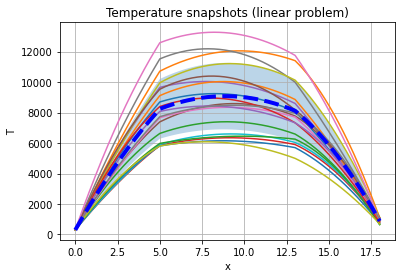

In [17]:
x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

T_snapshots = np.zeros((len(x),N_snapshots))

# boundary conditions
bc = {}
h = 10.
T_inf = 20.
bc_hco  = {"type": "natural"  , "value_a": h, "value_c": h*T_inf}
T_dir = 300.
bc_dir = {"type": "dirichlet", "value": T_dir}
bc_sym = {"type": "natural"  , "value_a": 0., "value_c": 0.}

bc["left"]  = bc_dir
bc["right"] = bc_hco


# loop to generate snapshots
for i in range(N_snapshots):
    # conductivity functions per zone
    # external volumetric heat source functions per zone
    cond_arr = []
    qext_arr = []
    for j in range(3):
        k = min_vals[j]    + dif_vals[j]  *randnumber[j  ,i]
        q = min_vals[j+3]  + dif_vals[j+3]*randnumber[j+3,i]
        cond_arr.append( lambda x_,k=k: k + 0.*x_)
        qext_arr.append( lambda x_,q=q: q + 0.*x_)
    cond_arr = np.asarray(cond_arr)
    qext_arr = np.asarray(qext_arr)

    # solve
    T_snapshots[:,i] = solve_linear_at_once(cond_arr, qext_arr, bc, xm, dx, mat2cell)

    
mean_temp = np.mean(T_snapshots,axis=1)
std_temp  = np.std(T_snapshots,axis=1)

plt.figure()
for i in range(19):
    plt.plot(x,T_snapshots[:,i])
plt.xlabel('x')
plt.ylabel('T')
plt.plot(x,mean_temp,'b--', linewidth=4, label='mean')
plt.fill_between(x,mean_temp-std_temp,mean_temp+std_temp,alpha=.3)
plt.title('Temperature snapshots (linear problem)')
plt.grid(True)

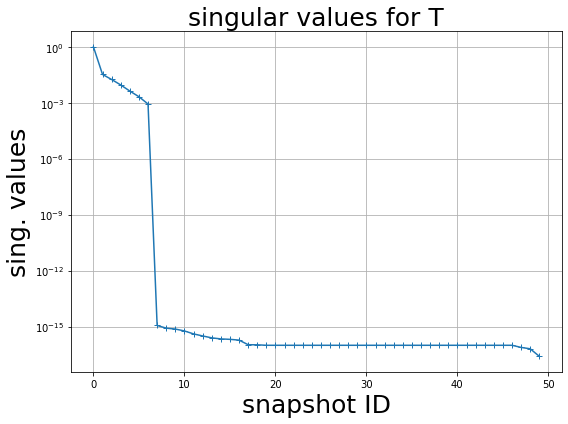

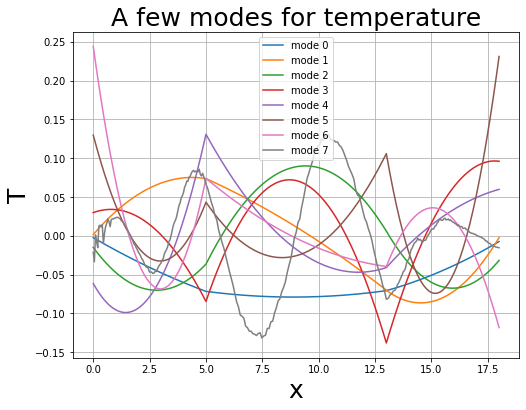

In [18]:
U_all, S, _ = np.linalg.svd(T_snapshots[:,:],full_matrices=False,compute_uv=True)

plt.figure(figsize=(8,6))
plt.semilogy(S/np.max(S),'-+')
plt.xlabel('snapshot ID',fontsize=25)
plt.ylabel('sing. values',fontsize=25)
plt.title('singular values for T',fontsize=25)
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for i in range(8):
    plt.plot(x,U_all[:,i],label='mode '+str(i))
    plt.grid(True)
    plt.legend()
    plt.title('A few modes for temperature',fontsize=25)
plt.xlabel('x',fontsize=25)
plt.ylabel('T',fontsize=25)
plt.show()